#Neural Machine Translation - Seq2Seq with Attention

In [1]:

#  !python -m spacy download xx_ent_wiki_sm
#  !python -m spacy download xx_sent_ud_sm

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# !pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 923.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [1]:
import spacy
import numpy as np
import random
import math
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.data import Field, TabularDataset, BucketIterator

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
spacy_en = spacy.load('en_core_web_sm')
spacy_tel = spacy.load('xx_sent_ud_sm')

In [5]:
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_tel(text):
    # Remove Zero Width Non-Joiner characters
    text = text.replace('\u200c', '')
    return [tok.text for tok in spacy_tel.tokenizer(text)]


In [6]:
SRC = Field(tokenize=tokenize_en,include_lengths = True, lower=True, init_token='<sos>', eos_token='<eos>')
TRG = Field(tokenize=tokenize_tel, lower=True, init_token='<sos>', eos_token='<eos>')


In [34]:
dataset = TabularDataset(
    path='/content/drive/MyDrive/Honors colabspace/MachineTranslation/final.csv', 
    format='csv',
    fields=[('English', SRC), ('Telugu', TRG)],
    skip_header=True
)
train_data, valid_data, test_data = dataset.split(split_ratio=[0.6, 0.3, 0.1])


In [35]:

for i in range(5):
    print(vars(train_data.examples[i])['English'])
    print(vars(train_data.examples[i])['Telugu'])
    print()


['andhra', 'pradesh', 'chief', 'minister', 'ys', 'jagan', 'mohan', 'reddy', 'was', 'also', 'present', 'on', 'the', 'occasion', '.']
['దానిలో', 'భాగంగానే', 'ప్రధాని', 'మోదీని', 'ఆంధ్రప్రదేశ్', 'ముఖ్యమంత్రి', 'వైఎస్', 'జగన్మోహన్రెడ్డి', 'కలిశారు', '.']

['should', 'i', 'quit', 'my', 'job', '?']
['నేను', 'నా', 'ఉద్యోగాన్ని', 'విడిచిపెట్టాలా', '?']

['singers']
['గాయకులు']

['music', ':', 'alokananda', 'dasgupta']
['సంగీతం', ':', 'అజనీశ్', 'లోకనాథ్']

['tom', 'has', 'never', 'driven', 'a', 'car', 'before', '.']
['టామ్', 'ఇంతకు', 'ముందెన్నడూ', 'కారు', 'నడపలేదు', '.']



In [36]:
SRC.build_vocab(train_data )
TRG.build_vocab(train_data)

In [10]:

BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.English),
     device = device)

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):

        embedded = self.dropout(self.embedding(src))

        #embedded = [src len, batch size, emb dim]

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))

        packed_outputs, hidden = self.rnn(packed_embedded)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        #outputs = [src len, batch size, enc hid dim * 2]
        

        return outputs, hidden

In [12]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)

    def forward(self, hidden, encoder_outputs, mask):  

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

       
        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))

        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)

        #attention = [batch size, src len]

        attention = attention.masked_fill(mask == 0, -1e10)

        return F.softmax(attention, dim = 1)

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs, mask):

        input = input.unsqueeze(0)  

        embedded = self.dropout(self.embedding(input))   

        a = self.attention(hidden, encoder_outputs, mask)

        a = a.unsqueeze(1)   

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        weighted = torch.bmm(a, encoder_outputs)
        
        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim = 2)

        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))


        return prediction, hidden.squeeze(0), a.squeeze(1)

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device

    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask

    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):


        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

       
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src, src_len)

        input = trg[0,:]

        mask = self.create_mask(src)

        for t in range(1, trg_len):

            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1

        return outputs

In [38]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.7
DEC_DROPOUT = 0.7
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [39]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6950, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(11808, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=11808, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
)

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 32,407,072 trainable parameters


In [41]:
optimizer = optim.Adam(model.parameters())


In [42]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [43]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src, src_len = batch.English
        trg = batch.Telugu

        optimizer.zero_grad()

        output = model(src, src_len, trg)

        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [44]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src, src_len = batch.English
            trg = batch.Telugu

            output = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [45]:

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 25s
	Train Loss: 6.754 | Train PPL: 857.616
	 Val. Loss: 6.493 |  Val. PPL: 660.456
Epoch: 02 | Time: 0m 25s
	Train Loss: 5.795 | Train PPL: 328.648
	 Val. Loss: 6.320 |  Val. PPL: 555.498
Epoch: 03 | Time: 0m 25s
	Train Loss: 5.337 | Train PPL: 207.917
	 Val. Loss: 6.408 |  Val. PPL: 606.770
Epoch: 04 | Time: 0m 25s
	Train Loss: 4.852 | Train PPL: 128.060
	 Val. Loss: 6.564 |  Val. PPL: 708.867


KeyboardInterrupt: ignored

In [47]:
# model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 6.949 | Test PPL: 1042.083 |


In [48]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)

    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention

        pred_token = output.argmax(1).item()

        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [28]:
def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=15)

    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [53]:
example_idx = 9

src = vars(train_data.examples[example_idx])['English']
trg = vars(train_data.examples[example_idx])['Telugu']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['but', 'there', "'s", 'nothing', 'much', 'they', 'can', 'do', '.']
trg = ['కానీ', 'ఇవేమి', 'పందేంరాయళ్లను', 'ఏమీ', 'చేయలేకపోతున్నాయి', '.']


In [54]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['కానీ', 'ఇవేమి', 'పందేంరాయళ్లను', 'చేయలేకపోతున్నాయి', '.', '<eos>']


<ipython-input-28-e3f1aa0bc34a>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-28-e3f1aa0bc34a>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3134 (\N{TELUGU VOWEL SIGN AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3112 (\N{TELUGU LETTER NA}) missing from current fon

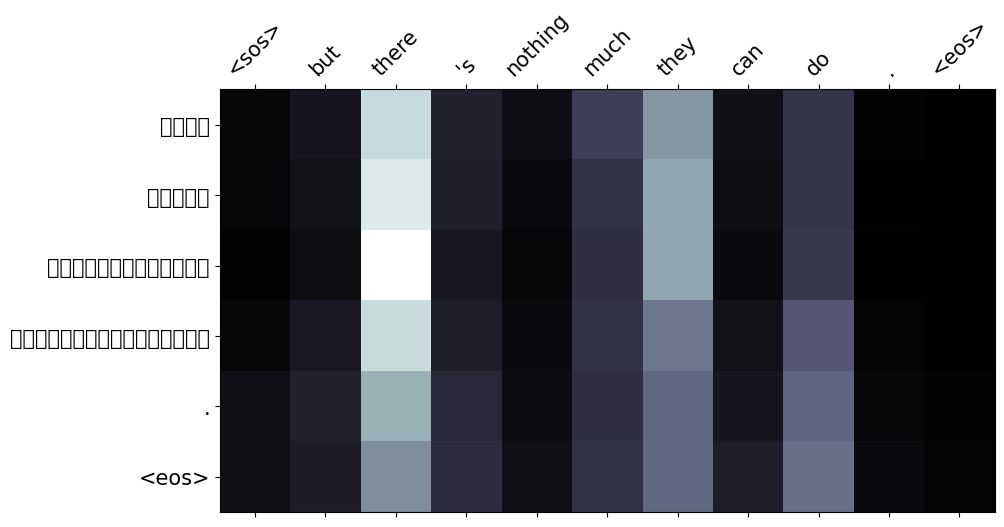

In [55]:
display_attention(src, translation, attention)


In [56]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['English']
        trg = vars(datum)['Telugu']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')